In [3]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
import tensorflow as tf
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense, AvgPool2D,MaxPool2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

Using TensorFlow backend.


In [5]:
import numpy as np 
import pandas as pd 
import nibabel as nib
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf

In [6]:
%matplotlib inline
import nibabel
import matplotlib.pyplot as plt
import numpy as np

In [7]:
data = pd.read_csv('.../dataset/metadata.csv')
file_path1 = os.path.join('.../dataset/ct_scans')
data.head(n=5)


,ct_scan,lung_mask,infection_mask,lung_and_infection_mask
0,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
1,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
2,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
3,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...
4,C:/Users/kzhan/Desktop/archive/ct_scans/corona...,C:/Users/kzhan/Desktop/archive/lung_mask/coron...,C:/Users/kzhan/Desktop/archive/infection_mask/...,C:/Users/kzhan/Desktop/archive/lung_and_infect...


In [8]:
def read_nii(file_path):
    ct_scan = nib.load(file_path)
    array   = ct_scan.get_fdata()
    array   = np.rot90(np.array(array))
    return(array)

In [9]:
sample_ct   = read_nii(data.loc[0,'ct_scan'])
sample_lung = read_nii(data.loc[0,'lung_mask'])
sample_infe = read_nii(data.loc[0,'infection_mask'])
sample_all  = read_nii(data.loc[0,'lung_and_infection_mask'])

Text(0.5, 1.0, 'Mask of Lungs of Original')

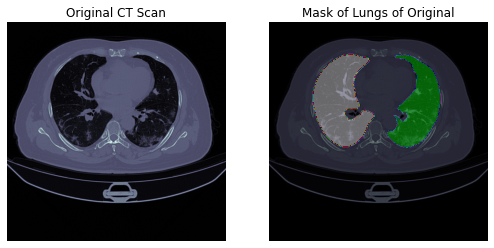

In [10]:
fig = plt.figure(figsize = (18,15))
plt.subplot(1,4,1)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.axis("off")
plt.title('Original CT Scan')

plt.subplot(1,4,2)
plt.imshow(sample_ct[..., 150], cmap = 'bone')
plt.imshow(sample_lung[..., 150],alpha = 0.5, cmap = 'nipy_spectral')
plt.axis("off")
plt.title('Mask of Lungs of Original')

In [11]:
def plot_sample(array_list, color_map = 'nipy_spectral'):
    fig = plt.figure(figsize=(18,15))

    plt.subplot(1,4,1)
    plt.imshow(array_list[0], cmap='bone')
    plt.axis("off")
    plt.title('Original Image')

    plt.subplot(1,4,2)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[1], alpha=0.5, cmap=color_map)
    plt.axis("off")
    plt.title('Lung Mask')

    plt.subplot(1,4,3)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[2], alpha=0.5, cmap=color_map)
    plt.axis("off")
    plt.title('Infection Mask')

    plt.subplot(1,4,4)
    plt.imshow(array_list[0], cmap='bone')
    plt.imshow(array_list[3], alpha=0.5, cmap=color_map)
    plt.axis("off")
    plt.title('Lung and Infection Mask')

    plt.show()

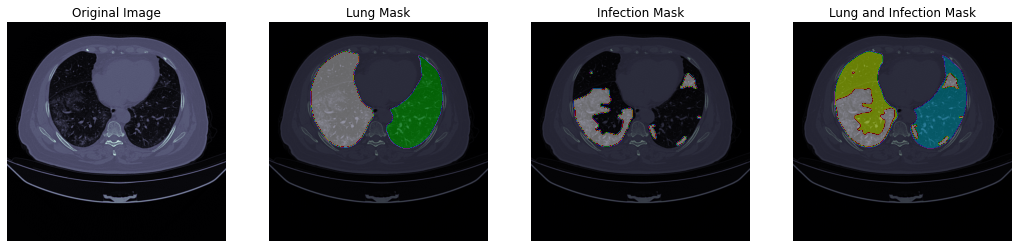

In [12]:
plot_sample([sample_ct[...,120], sample_lung[...,120], sample_infe[...,120], sample_all[...,120]])

In [13]:
lungs = []
infections = []
img_size = 128

for i in range(len(data)):
    ct = read_nii(data['ct_scan'][i])
    infect = read_nii(data['infection_mask'][i])
    
    for ii in range(ct.shape[0]):
        lung_img = cv2.resize(ct[ii], 
        dsize = (img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')

        infec_img = cv2.resize(infect[ii],
        dsize=(img_size, img_size),interpolation = cv2.INTER_AREA).astype('uint8')
        
        lungs.append(lung_img[..., np.newaxis])
        infections.append(infec_img[..., np.newaxis])

In [18]:
lungs = np.array(lungs)
infections = np.array(infections)

print(lungs.shape)
print(infections.shape)

(11191, 128, 128, 1)
(11191, 128, 128, 1)


In [19]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

def build_model(input_layer, start_neurons):
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)
    
    return output_layer

input_layer = Input((img_size, img_size, 1))
output_layer = build_model(input_layer, 16)

In [20]:
from sklearn.model_selection import train_test_split
lung_train, lung_test, infect_train, infect_test = train_test_split(lungs, infections, test_size = 0.1)

In [21]:
output = build_model(input_layer, 16)
model = Model(input_layer, output_layer)
model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [22]:
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 1) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 160         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 16) 2320        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 64, 64, 16)   0           conv2d_1[0][0]                   
_______________________________________________________________________________________

In [23]:
history = model.fit(lung_train, infect_train, epochs = 5, validation_data = (lung_test, infect_test))

Epoch 1/5
315/315 [==============================] - 526s 2s/step - loss: 0.0487 - accuracy: 0.9921 - val_loss: 0.0385 - val_accuracy: 0.9934
Epoch 2/5
315/315 [==============================] - 435s 1s/step - loss: 0.0217 - accuracy: 0.9930 - val_loss: 0.0294 - val_accuracy: 0.9940
Epoch 3/5
315/315 [==============================] - 445s 1s/step - loss: 0.0174 - accuracy: 0.9939 - val_loss: 0.0178 - val_accuracy: 0.9948
Epoch 4/5
315/315 [==============================] - 435s 1s/step - loss: 0.0149 - accuracy: 0.9947 - val_loss: 0.0172 - val_accuracy: 0.9951
Epoch 5/5
315/315 [==============================] - 462s 1s/step - loss: 0.0140 - accuracy: 0.9949 - val_loss: 0.0130 - val_accuracy: 0.9960


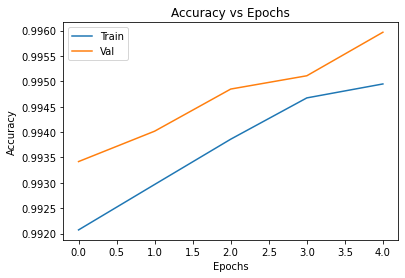

In [24]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epochs')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

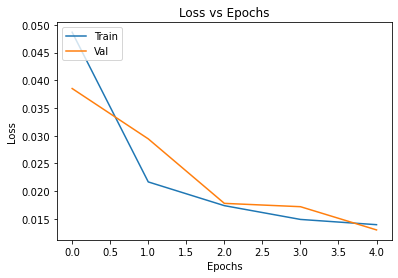

In [25]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['Train', 'Val'], loc = 'upper left')
plt.show()

Text(0.5, 1.0, 'predicted infection mask')

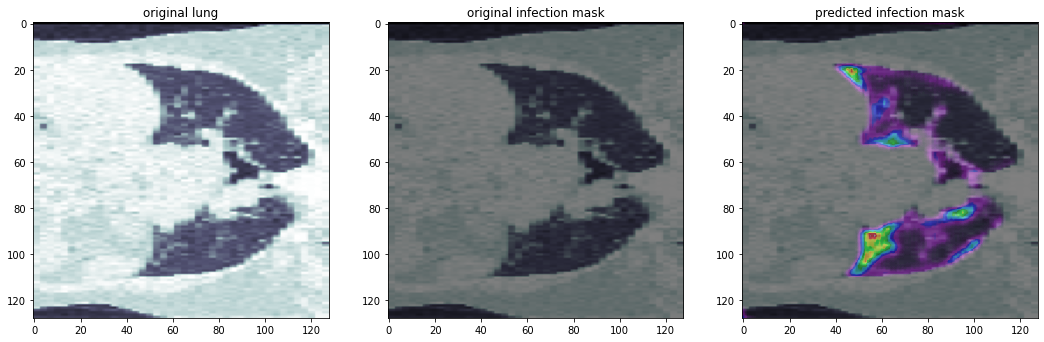

In [28]:
predicted = model.predict(lung_test)
fig = plt.figure(figsize = (18,15))

plt.subplot(1,3,3)
plt.imshow(lung_test[550][...,0], cmap = 'bone')
plt.imshow(predicted[550][...,0],alpha = 0.5,cmap = "nipy_spectral")
plt.axis("off")
plt.title('predicted infection mask')